In [143]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import logit, mnlogit
from statsmodels.tools.tools import add_constant
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Setting

We will look at a dataset concerning maternal mortality from [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/maternal-health-risk). The columns of interest are as follows:

* **SystolicBP**: The upper value of the patient's blood pressure in mmHg.
* **HeartRate**: The patient's heartbeats per minute.
* **RiskLevel**: The patient's predicted risk of maternal mortality during pregnancy. There are three levels of increasing risk:
*low risk*, *mid risk*, and *high risk*.

In [144]:
data = pd.read_csv('maternal_mortality_risk.csv')
data = data[["SystolicBP","HeartRate","RiskLevel"]]
data 

,SystolicBP,HeartRate,RiskLevel
0,130,86,high risk
1,140,70,high risk
2,90,80,high risk
3,140,70,high risk
4,120,76,low risk
...,...,...,...
1009,120,80,high risk
1010,120,60,high risk
1011,85,86,high risk
1012,120,70,high risk


# Part 1 [4 pts]

Estimate a multinomial logit model that predicts **RiskLevel** given covariates **SystolicBP** and **HeartRate**. Treat *low risk* as the baseline option. You may use `mnlogit()` from `statsmodels`. Show the model summary.

In [145]:
data['RiskLevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [146]:
data['Risk_num'] = data['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})
model = mnlogit("Risk_num~SystolicBP + HeartRate", data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.971944
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               Risk_num   No. Observations:                 1014
Model:                        MNLogit   Df Residuals:                     1008
Method:                           MLE   Df Model:                            4
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.1046
Time:                        00:06:47   Log-Likelihood:                -985.55
converged:                       True   LL-Null:                       -1100.7
Covariance Type:            nonrobust   LLR p-value:                 1.192e-48
==============================================================================
Risk_num=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3573      0.957     -5.595      0.000      -7.234      -3.481
SystolicBP     0.0260      0.004      5.878      0.000       0.017       0.035
HeartRate      0.0315      0.010      3.139      0.002       0.012       0.051
------------------------------------------------------------------------------
Risk_num=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.5764      1.228    -11.869      0.000     -16.983     -12.169
SystolicBP     0.0692      0.006     11.861      0.000       0.058       0.081
HeartRate      0.0829      0.012      6.748      0.000       0.059       0.107
==============================================================================
"""

# Part 2 [12 pts]

Suppose we assign the following costs to each risk level:
* low risk: 100
* medium risk: 1000
* high risk: 5000

We will also be able to implement a treatment plan to help patients lower their **SystolicBP** levels. The cost is $\Delta^2$, where $\Delta$ is the amount by which **SystolicBP** is reduced from the starting level.

The expected cost associated with a patient is thus the weighted sum of the risk costs, where the weights are the respective probabilities of each risk level, plus the cost of the treatment plan.

We implement this treatment plan for a patient who currently has **SystolicBP** $=160$ and **HeartRate** $=80$. 

* Compute and show the probabilities of this patient's risk levels, as well as their current expected cost. 

* Compute and plot the expected cost of the patient against values of **SystolicBP** *after* the treatment. For example, **SystolicBP** $=150$ would contribute an expected cost of $\Delta^2=10^2=100$. Plot from the range $80$ to $160$.

* Compute and show the optimal **SystolicBP** value that minimizes expected cost. Also compute the probabilities of the patient's risk levels, as well as the expected cost itself.


In [147]:
costs = {0: 100, 1: 1000, 2: 5000}
sysBP = 160
hr = 80
patient_num = pd.DataFrame({
    'SystolicBP': [sysBP],
    'HeartRate': [hr]
})
pred = model.predict(patient_num)
pred

,0,1,2
0,0.036011,0.136119,0.82787


In [148]:
print('Probability of Low risk:', pred[0], '\nProbability of mid risk:', pred[1], '\nProbability of high risk:', pred[2])

Probability of Low risk: 0    0.036011
Name: 0, dtype: float64 
Probability of mid risk: 0    0.136119
Name: 1, dtype: float64 
Probability of high risk: 0    0.82787
Name: 2, dtype: float64


In [149]:
exp_cost = np.sum(pred * costs)
print(sum(exp_cost))

4279.069506117661


In [150]:
exp_list = []
min_exp = 100000
optimal_sysbp = 0

80
80


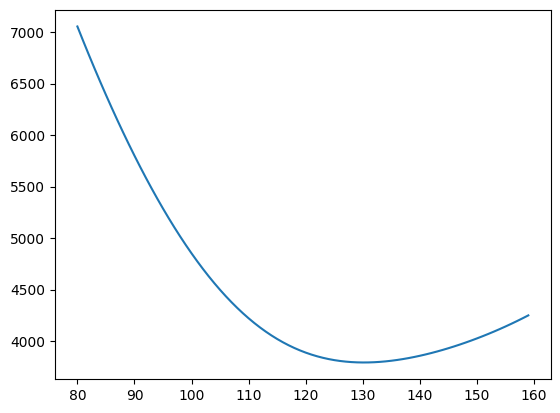

In [151]:
sysbp_list = np.arange(80, 160)
for i in sysbp_list:
    delta2 = (160 - i) ** 2
    patient_num_i = pd.DataFrame({
        'SystolicBP': [i],
        'HeartRate': [hr]
    })

    pred_i = model.predict(patient_num_i)
    exp_cost_i = np.sum(pred_i * costs)
    expected_cost = sum(exp_cost_i) + delta2
    if expected_cost < min_exp:
        min_exp = expected_cost
        optimal_sysbp = i

    exp_list.append(expected_cost)

    
print(len(exp_list))
print(len(sysbp_list))

plt.plot(sysbp_list, exp_list)
plt.show()


In [152]:
optimal_sysbp, min_exp

(130, 3792.5663741211265)

In [153]:
patient_num_final = pd.DataFrame({
        'SystolicBP': [optimal_sysbp],
        'HeartRate': [hr]
        })

pred_final = model.predict(patient_num_final)
print("low, mid, high risk's probability as: ", pred_final)

low, mid, high risk's probability as:            0         1         2
0  0.178208  0.308553  0.513238


# Part 3 [2 pts]

Now estimate an ordinal logit model. You may use `OrderedModel` from `statsmodels()`. Show the model summary.

In [154]:
ordinal = OrderedModel(data["Risk_num"], data[["SystolicBP", "HeartRate"]]).fit()
ordinal.summary()

Optimization terminated successfully.
         Current function value: 0.972994
         Iterations: 168
         Function evaluations: 287


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               Risk_num   Log-Likelihood:                -986.62
Model:                   OrderedModel   AIC:                             1981.
Method:            Maximum Likelihood   BIC:                             2001.
Date:                Tue, 22 Oct 2024                                         
Time:                        00:06:48                                         
No. Observations:                1014                                         
Df Residuals:                    1010                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SystolicBP     0.0286      0.002     13.268      0.000       0.024       0.033
HeartRate      0.0351      0.005      7.137      0.000       0.025       0.045
0/1            5.5439      0.460     12.057      0.000       4.643       6.445
1/2            0.0035      0.047      0.074      0.941      -0.089       0.096
==============================================================================
"""

# Part 4 [12 pts]

Repeat Part 2 using the estimated ordinal logit model.

Suppose we assign the following costs to each risk level:
* low risk: 100
* medium risk: 1000
* high risk: 5000

We will also be able to implement a treatment plan to help patients lower their **SystolicBP** levels. The cost is $\Delta^2$, where $\Delta$ is the amount by which **SystolicBP** is reduced from the starting level.

The expected cost associated with a patient is thus the weighted sum of the risk costs, where the weights are the respective probabilities of each risk level, plus the cost of the treatment plan.

We implement this treatment plan for a patient who currently has **SystolicBP** $=160$ and **HeartRate** $=80$. 

* Compute and show the probabilities of this patient's risk levels, as well as their current expected cost. 

* Compute and plot the expected cost of the patient against values of **SystolicBP** *after* the treatment. For example, **SystolicBP** $=150$ would contribute an expected cost of $\Delta^2=10^2=100$. Plot from the range $80$ to $160$.

* Compute and show the optimal **SystolicBP** value that minimizes expected cost. Also compute the probabilities of the patient's risk levels, as well as the expected cost itself.


In [155]:
costs = {0: 100, 1: 1000, 2: 5000}
sysBP = 160
hr = 80
patient_num = pd.DataFrame({
    'SystolicBP': [sysBP],
    'HeartRate': [hr]
})
pred = ordinal.predict(patient_num)
pred

,0,1,2
0,0.032822,0.168375,0.798804


In [156]:
print('Probability of Low risk:', pred[0], '\nProbability of mid risk:', pred[1], '\nProbability of high risk:', pred[2])

Probability of Low risk: 0    0.032822
Name: 0, dtype: float64 
Probability of mid risk: 0    0.168375
Name: 1, dtype: float64 
Probability of high risk: 0    0.798804
Name: 2, dtype: float64


In [157]:
model_params = ordinal.params
beta = model_params[0:2] 
x = np.array([160, 80])
cut_base = model_params[2]
increments = np.exp(model_params[3:])
cutoffs = np.cumsum(np.insert(increments, 0, cut_base))
utilities = cutoffs - np.dot(beta, x)
exp_terms = np.exp(utilities) / (1 + np.exp(utilities)) 
probabilities = np.diff(np.insert(exp_terms, 0, 0)) 
probabilities = np.append(probabilities, 1 - exp_terms[-1])
print("Utility for x: ", np.dot(beta, x)) 
print("Cutoffs: ", cutoffs) 
print("Probabilities: ", probabilities)

Utility for x:  7.38473991477331
Cutoffs:  [5.54388645 6.54738367]
Probabilities:  [0.13695039 0.1651415  0.69790812]


In [158]:
exp_cost = np.sum(pred * costs)
print(sum(exp_cost))

4165.67593021436


In [159]:
exp_list = []
min_exp = 100000
optimal_sysbp = 0

80
80


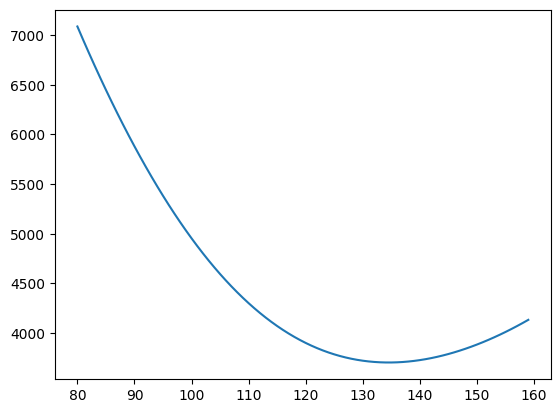

In [160]:
sysbp_list = np.arange(80, 160)
for i in sysbp_list:
    delta2 = (160 - i) ** 2
    patient_num_i = pd.DataFrame({
        'SystolicBP': [i],
        'HeartRate': [hr]
    })

    pred_i = ordinal.predict(patient_num_i)
    exp_cost_i = np.sum(pred_i * costs)
    expected_cost = sum(exp_cost_i) + delta2

    if expected_cost < min_exp:
        min_exp = expected_cost
        optimal_sysbp = i

    exp_list.append(expected_cost)

    
print(len(exp_list))
print(len(sysbp_list))

plt.plot(sysbp_list, exp_list)
plt.show()


In [161]:
optimal_sysbp, min_exp

(135, 3702.5672253286652)

In [162]:
patient_num_final = pd.DataFrame({
        'SystolicBP': [optimal_sysbp],
        'HeartRate': [hr]
        })

pred_final = ordinal.predict(patient_num_final)
print("low, mid, high risk's probability as: ", pred_final)

low, mid, high risk's probability as:            0         1        2
0  0.130125  0.321205  0.54867
